# Monte Carlo Simulations in Finance with Python

In this notebook, I shall introduce 2 use cases of Monte Carlo simulations in finance; for forecasting future stock prices and portfolio optimization

### Stock Price Predictions

Monte Carlo (MC) simulations are useful for forecasting things like Max DD, in optimization problems or complex scenarios like the probability of your savings being sufﬁcient for retirement expenses. But they're primarily used for two key parts of development; Portfolio Selection/Optimization, and System/ Portfolio Stress Testing.

MC simulations are models used to model the probability of complex events by compiling thousands - millions of various outcomes with a pre-determined ‘random’ (changing) variable. Essentially you run several iterations with random values for a speciﬁc variable, in hopes of ﬁnding an optimum value or determining a range of possible outcomes — i.e. using randomness to solve a complex problem — for example % Risk of Ruin with a portfolio, given its return characteristics (Mean, Std), and initial balance.

In the first section we will look at its application in predicting future stock prices.

$$
{Price_t}={Price_{t-1} * e^r}
$$

* We know previous time period's price. 

* We want to predict current price. 

* What we do not know is the rate of return, r, of the share price between previous and current time periods. 

This is where the Monte Carlo simulation comes in!

### Brownian Motion

Brownian motion will be the main driver for estimating the return. It is a stochastic process used for modeling random behavior over time.

**Brownian Motion** has two main main components:
1. Drift - the direction that rates of returns have had in the past. That is, the expected return of the stock.
$$
{Drift} = ({mean} - \frac{1}{2} {Var})
$$

    We multiply the variance by 0.5 because historical values are eroded in the future.
    

2. Volatility -  random variable. This is the historical volatility multiplied by a random, standard normally distributed variable.

$$
{Volatility} = {Std.Dev. * Z([Rand(0;1)])}
$$

Therefore, our asset pricing equation ends up looking like this:

$$
{Price_t}={Price_{t-1} * e^{mean-\frac{1}{2}{Var} + Std.Dev * Z([Rand(0;1)])}}
$$



This technique will be used for every time period into the future you want to predict, and for however many trials the monte carlo simulation will run!

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from datetime import datetime

%matplotlib inline

We first define a function to load and preprocess the data into a suitable dataframe.

In [2]:
def load_preprocess_data(data_folder_path='data'):
    
#     Create empty dataframe
    data = pd.DataFrame()
    
#     Iterate through the list of stocks in the folder
    for i, ticker in enumerate(os.listdir(data_folder_path)):
        
#         Join folder path to filename to be read by pandas
        path = os.path.join(data_folder_path, ticker)
#         read in 3 columns; year and time as a single datetime column, and close price of the stock
        ticker_df = pd.read_csv(path, usecols=[1, 2, 6], names=['Year', 'Time', ticker], parse_dates={'date_time':['Year', 'Time']})
#         merge dfs of each stock into a single one
        try:
            data = data.merge(ticker_df, left_on=['date_time'], right_on=['date_time'])
        except KeyError:
            data = ticker_df
#      strip out '.txt' from the column names       
    data.columns = data.columns.str.strip('.txt')
    
#     set NIFTY as last column for consistency
    last_col = data.pop('NIFTY')
    data.insert(len(data.columns), 'NIFTY', last_col)
    
#     set date_time column as index for slicing later
    data.set_index('date_time', inplace=True)
    
    return data

In [3]:
data = load_preprocess_data()
data

,ASIANPAINT,AXISBANK,APOLLOTYRE,ASHOKLEY,AMBUJACEM,ADANIENT,NIFTY
date_time,,,,,,,
2021-03-01 09:08:00,2300.00,738.00,235.00,130.70,275.55,840.75,14702.50
2021-03-01 09:16:00,2309.70,733.65,237.40,132.65,276.65,845.55,14667.00
2021-03-01 09:17:00,2311.95,734.55,237.50,133.10,276.35,844.65,14688.00
2021-03-01 09:18:00,2310.00,733.85,236.00,131.60,275.15,840.85,14677.55
2021-03-01 09:19:00,2314.10,732.30,235.70,131.70,275.25,841.90,14682.75
...,...,...,...,...,...,...,...
2021-03-31 15:26:00,2538.90,696.60,223.25,113.50,308.85,1031.55,14687.65
2021-03-31 15:27:00,2541.60,696.05,222.70,113.50,309.20,1031.50,14690.60
2021-03-31 15:28:00,2541.00,696.85,222.70,113.45,309.25,1031.15,14689.30


Then, we compute the returns of the data. Log is more commonly used as it implies contiuous compounding which is most likely to be the case for liquid securities being traded on the exchange.

In [4]:
# Add 1 to the percent change to give the value of the holding, for cumulative multiplication.
def log_returns(data):
    return np.log(1+data.pct_change()).dropna()

In [5]:
log_return = log_returns(data)
log_return.head()

,ASIANPAINT,AXISBANK,APOLLOTYRE,ASHOKLEY,AMBUJACEM,ADANIENT,NIFTY
date_time,,,,,,,
2021-03-01 09:16:00,0.004209,-0.005912,0.010161,0.014809,0.003984,0.005693,-0.002417
2021-03-01 09:17:00,0.000974,0.001226,0.000421,0.003387,-0.001085,-0.001065,0.001431
2021-03-01 09:18:00,-0.000844,-0.000953,-0.006336,-0.011334,-0.004352,-0.004509,-0.000712
2021-03-01 09:19:00,0.001773,-0.002114,-0.001272,0.000760,0.000363,0.001248,0.000354
2021-03-01 09:20:00,0.001684,0.001705,0.002119,0.002654,-0.001091,0.003320,0.001337


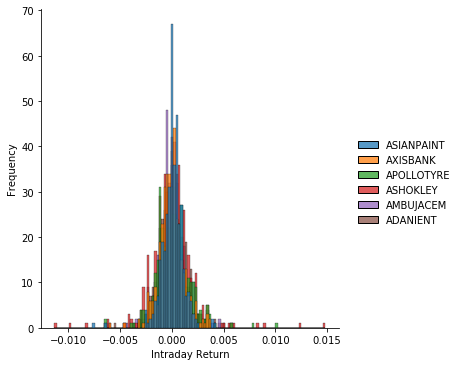

In [6]:
# Histogram of 1st day's log returns (approx 375 trading minutes per day)
sns.displot(log_return.iloc[:375, :-1])
plt.xlabel("Intraday Return")
plt.ylabel("Frequency");

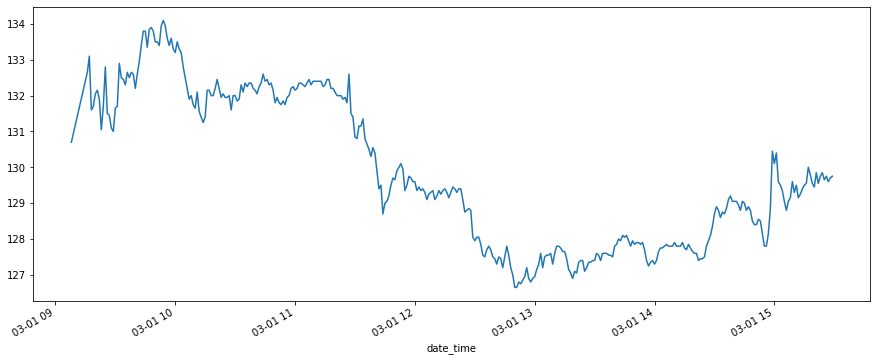

In [7]:
data.iloc[:375,3].plot(figsize=(15,6));

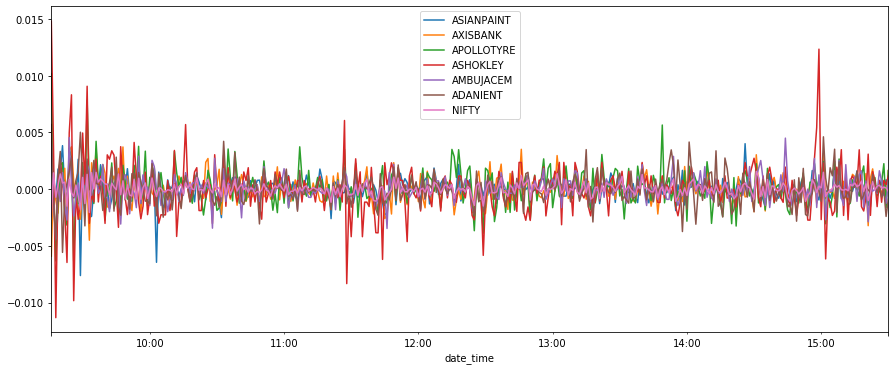

In [8]:
log_return.iloc[:375, :].plot(figsize=(15,6));
# NIFTY appears to be least volatile while Ashok Leyland has the most noise swings

## CAPM and Sharpe

Before we jump into Monte Carlo Simulations, we would like to report some statistics with it, including the Beta and Sharpe Ratio of the stock, compared to the _market portfolio_. To understand these metrics, we first must understand the underlying concepts of the _Capital Asset Pricing Model,_ starting with the _market portfolio_.

* The market portfolio is the theoretical combination of all possible investments in the world. However, there is no such thing as a market portfolio in reality. We approximate it with a stock market index in our case NIFTY

* We also note that there is no such thing as a risk-free asset. We will use RBI 91-Day Treasury Bill (Primary) Yield at 3.32% (taken from https://www.rbi.org.in/Scripts/BS_NSDPDisplay.aspx?param=4)

We use the _market portfolio_ to compute the Beta, the CAPM expected return, and the Sharpe Ratio of a stock.
1. **Beta**: measures the market risk that cannot be avoided through diversification. This is the relationship between the stock and the market portfolio. In other words, it is a measure of how much risk the investment will add to a portfolio that looks like the market.
##### $$ 
\beta_{i} = \frac{\sigma_{i,m}}{\sigma_{m}^2}
$$

        When beta = 0, it means that there's no relationship.
    
        When beta < 1, it means that the stock is defensive (less prone to high highs and low lows)
    
        When beta > 1, it means that the stock is aggresive (more prone to high highs and low lows)
    
    
2. **Expected Return CAPM**: calculates the expected return of a security adjusted to the risk taken. This equates to the return expected from taking the extra risk of purchasing this security.
##### $$
\overline{r_{i}} = r_f + \beta_{i}(\overline{r_{m}} - r_f) 
$$

3. **Sharpe Ratio**: measures the performance of a security compared to a risk-free asset, after adjusting for its risk. This is the excess return per unit of risk of an investment.
##### $$
Sharpe = \frac{\overline{r_{i}} - r_f}{\sigma_{i}}
$$
        When Sharpe > 1, GOOD risk-adjusted returns
    
        When Sharpe > 2, VERY GOOD risk-adjusted returns
    
        When Sharpe > 3, EXCELLENT risk-adjusted returns
    

Annualization is used to standardize rates of different time frames for comparison. Here, since we have minute data we multiply minutes by trading hours in a day by trading days in a year. All the metrics we compute will be at the minute level and then annualized.

In [9]:
annualizer = 252 * 6.25 * 60
annualizer

94500.0

In [10]:
def beta_sharpe(data, riskfree = 0.0332):
    
    """
    Input: 
    1. data: dataframe of stock price data
    2. riskfree: RBI 91-Day Treasury Bill (Primary) Yield at 3.32% (taken from https://www.rbi.org.in/Scripts/BS_NSDPDisplay.aspx?param=4)
    
    Output:
    1. Dataframe with CAPM metrics computed against NIFTY
    """
    # Beta
    log_ret = log_returns(data)
    covar = log_ret.cov()*annualizer
    covar = pd.DataFrame(covar.iloc[:,-1])
    mrk_var = log_ret.iloc[:,-1].var()*annualizer
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*annualizer**0.5)), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    try:
        mark_ret = np.exp(log_ret['NIFTY'].mean()*annualizer).values-1
    except:
        mark_ret = np.exp(log_ret['NIFTY'].mean()*annualizer)-1
    
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row['NIFTY'] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"NIFTY":"Beta"}, inplace=True)
    
    return beta

Let's see the intermediate outputs through each step of the function. We already have a combined data set from the previous function call. We'll then compute the log returns, covariance, beta, CAPM and sharpe.

In [11]:
log_ret = log_returns(data)
log_ret.head()

,ASIANPAINT,AXISBANK,APOLLOTYRE,ASHOKLEY,AMBUJACEM,ADANIENT,NIFTY
date_time,,,,,,,
2021-03-01 09:16:00,0.004209,-0.005912,0.010161,0.014809,0.003984,0.005693,-0.002417
2021-03-01 09:17:00,0.000974,0.001226,0.000421,0.003387,-0.001085,-0.001065,0.001431
2021-03-01 09:18:00,-0.000844,-0.000953,-0.006336,-0.011334,-0.004352,-0.004509,-0.000712
2021-03-01 09:19:00,0.001773,-0.002114,-0.001272,0.000760,0.000363,0.001248,0.000354
2021-03-01 09:20:00,0.001684,0.001705,0.002119,0.002654,-0.001091,0.003320,0.001337


We compute the annualized covariance matrix. Then select the last column as that contains the covariance of stocks against the index.

In [12]:
covar = log_ret.cov()*annualizer
covar

,ASIANPAINT,AXISBANK,APOLLOTYRE,ASHOKLEY,AMBUJACEM,ADANIENT,NIFTY
ASIANPAINT,0.085809,0.039076,0.034626,0.040163,0.028399,0.033981,0.028492
AXISBANK,0.039076,0.148303,0.065428,0.072437,0.044138,0.071210,0.054681
APOLLOTYRE,0.034626,0.065428,0.203341,0.097792,0.053354,0.080209,0.043648
ASHOKLEY,0.040163,0.072437,0.097792,0.215247,0.056178,0.086081,0.046569
AMBUJACEM,0.028399,0.044138,0.053354,0.056178,0.124720,0.053202,0.030031
ADANIENT,0.033981,0.071210,0.080209,0.086081,0.053202,0.256814,0.043843
NIFTY,0.028492,0.054681,0.043648,0.046569,0.030031,0.043843,0.036487


In [13]:
covar = pd.DataFrame(covar.iloc[:,-1])
covar

,NIFTY
ASIANPAINT,0.028492
AXISBANK,0.054681
APOLLOTYRE,0.043648
ASHOKLEY,0.046569
AMBUJACEM,0.030031
ADANIENT,0.043843
NIFTY,0.036487


Then we compute the annualized index variance (last column of returns) and beta.

In [14]:
mrk_var = log_ret.iloc[:,-1].var()*annualizer
beta = covar/mrk_var
mrk_var, beta

(0.03648728860129857,
                NIFTY
 ASIANPAINT  0.780865
 AXISBANK    1.498627
 APOLLOTYRE  1.196253
 ASHOKLEY    1.276308
 AMBUJACEM   0.823054
 ADANIENT    1.201593
 NIFTY       1.000000)

Then the annual standard deviation and merge it to the beta dataframe

In [15]:
stdev_ret = pd.DataFrame(((log_ret.std()*annualizer**0.5)), columns=['STD'])
stdev_ret

,STD
ASIANPAINT,0.292932
AXISBANK,0.385101
APOLLOTYRE,0.450934
ASHOKLEY,0.463948
AMBUJACEM,0.353157
ADANIENT,0.506768
NIFTY,0.191016


In [16]:
beta = beta.merge(stdev_ret, left_index=True, right_index=True)
beta

,NIFTY,STD
ASIANPAINT,0.780865,0.292932
AXISBANK,1.498627,0.385101
APOLLOTYRE,1.196253,0.450934
ASHOKLEY,1.276308,0.463948
AMBUJACEM,0.823054,0.353157
ADANIENT,1.201593,0.506768
NIFTY,1.000000,0.191016


Lastly, iterating through the beta dataframe we add the CAPM and sharpe, creating columns for each to give the final statistical metrics output.

In [17]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
ASIANPAINT,0.780865,0.292932,0.001303,-0.108888
AXISBANK,1.498627,0.385101,-0.028016,-0.158961
APOLLOTYRE,1.196253,0.450934,-0.015665,-0.108363
ASHOKLEY,1.276308,0.463948,-0.018935,-0.112372
AMBUJACEM,0.823054,0.353157,-0.000420,-0.095199
ADANIENT,1.201593,0.506768,-0.015883,-0.096854
NIFTY,1.000000,0.191016,-0.007648,-0.213846


**Brownian Motion**

Now that we have our returns, we can compute the brownian motion, as explained in the introduction.
1. Calculate the drift
2. Calculate the variance
3. Calculate the daily returns based on the drift and variance

In [18]:
def drift_calc(data):
    lr = log_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [19]:
drift_calc(data)

array([ 1.21871306e-05, -7.78070540e-06, -7.16163921e-06, -1.92468939e-05,
        1.37968109e-05,  2.44170551e-05, -2.74297106e-07])

We calculated the drift above, but now, we must calculate the minutely returns for the data. There are things to consider:
1. How many minutes into the future will we predict? (How many rows)
2. How many iterations of these predictions will we compute? (How many columns)

This generates the minutely returns (not prices!) for each minute into the future for each iteration (simulation) based on a normal distribution.

In the last line of the next function we lay the foundation for computing the Monte Carlo simulation. It creates an array with each minute as a subarray containing elements of random values between 0 and 1, equal to the number of iterations, effectively a minutes by iterations matrix.

**Note**: The following functions are meant to be run over a single column of the dataframe of tickers as we iterate through.

In [20]:
def intraday_returns(data, minutes, iterations):
    ft = drift_calc(data)
    try:
        stv = log_returns(data).std().values
    except:
        stv = log_returns(data).std()    
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(minutes, iterations)))
    return dr

In [21]:
# ex of 10 simulations for 10 minutes for Asian Paint
intraday_returns(data.iloc[:, 0], 10, 10)

array([[0.99871675, 0.99764373, 1.00023569, 1.00022928, 0.99982382,
        0.99805306, 0.99926715, 0.9987484 , 1.00036661, 1.00122953],
       [0.99995243, 0.99971771, 0.99866544, 1.00106479, 0.99858926,
        1.00052975, 0.99944241, 0.99984761, 1.00064102, 0.99875895],
       [1.00081915, 0.99981738, 0.99937114, 0.99983743, 1.00104225,
        1.00105646, 0.99859315, 1.00130431, 0.9997868 , 1.00000405],
       [1.00125136, 0.99925337, 1.00116859, 0.99993766, 1.00034994,
        1.00073454, 0.9999303 , 1.0003933 , 1.00092618, 1.00001801],
       [1.00016979, 1.00021869, 0.99902266, 1.00005496, 0.99917625,
        1.00115278, 1.00040833, 0.99991702, 0.99891486, 0.99987076],
       [1.00049455, 0.99948114, 0.99916227, 0.99999645, 0.99968107,
        1.00095635, 1.00040638, 0.99999418, 0.99964933, 0.99841052],
       [0.99845449, 0.99941818, 1.00031356, 1.00175834, 1.00009864,
        0.9996738 , 0.99993753, 0.99939583, 0.99937379, 1.00155478],
       [1.00050268, 0.99963994, 0.9996463

**Note**: This next function is used to calculate the probability of a stock having a higher price or higher returns than specified over the period defined. 

In [22]:
def probs_find(predicted, threshhold, on = 'value'):
    """
    This function calculates the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (minutes and simulations)
    2. threshhold: specified threshhold to which the probability's computed (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
#         set initial value as the start point
        predicted0 = predicted.iloc[0,0]
    
#         save the final ie target minute's simulated values as a list
        predicted = predicted.iloc[-1]
        pred_list = list(predicted)
        
#         make 2 lists for returns on initial value for those that are above and below the threshhold respectively
        over = [(i*100)/predicted0 for i in pred_list if ((i-predicted0)*100)/predicted0 >= threshhold]
        less = [(i*100)/predicted0 for i in pred_list if ((i-predicted0)*100)/predicted0 < threshhold]
    
    elif on == 'value':
#         same as above except here we calculate absolute value of stock, not relative to initial value
        predicted = predicted.iloc[-1]
        pred_list = list(predicted)
        over = [i for i in pred_list if i >= threshhold]
        less = [i for i in pred_list if i < threshhold]
    else:
        print("'on' must be either value or return")
        
#     lastly return the proportion (computed probability) of hitting the target threshhold
    return (len(over)/(len(over)+len(less)))

Example: We would like to find out the probability that our position in ASHOKLEY will breakeven or make a profit over the course of the day. There are two ways we can do this:
1. Returns = 0
2. Final stock price = initial stock price

So, with the simulation predicted values, we will predict said probabilities.

---
1. Calculate the intraday returns for every minute and every iteration (simulation) of the data. 
2. Creates an equally large matrix of size [minutes x iteration] full of zeroes.
3. Input the last stock price value in the first row (minute 0) of the "empty" matrix. This is our starting point.
4. Calculate "current minute's price" based on previous minute's multiplied by the intraday return generated. That is, multiply the intraday return generated for every simulation with the stock price calculated for the previous minute (the previous row) for every simulation.

The fourth step multiplies the intraday returns with the stock price of the previous minute.

In [23]:
def simulate_mc(data, minutes, iterations, plot=True):
    
    # Generate minute returns
    returns = intraday_returns(data, minutes+1, iterations)
    
    # Create empty matrix with dimensions of 'returns' matrix (all values are 0)
    price_list = np.zeros_like(returns)
    
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    
    # Calculate the price of each minute
    for t in range(1, minutes+1):
        price_list[t] = price_list[t-1]*returns[t]
    
    price_list = pd.DataFrame(price_list)
    
    # Plot Option
    if plot == True:
#         select the final returns simulation row
        x = price_list.iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(name) for name in data.columns]
    except:
        print(data.name)
    print(f"Minutes: {minutes}")
    
#     average final simulated value of security
    simulated_ev = round(price_list.iloc[-1].mean(), 2)
    print(f"Expected Value: ${simulated_ev}")
    
#     profit margin of average final simulated value of security based on initial price 
    print(f"Return: {round(100*(simulated_ev-price_list.iloc[0,1])/simulated_ev, 2)}%")
    
    
    print(f"Probability of Breakeven: {probs_find(price_list,0, on='return')}")
   
          
    return price_list

In [24]:
# 10k simulations for price of Asian Paints 20 mins ahead
simulate_mc(data.iloc[:,0], 20, 100000, plot=False)

ASIANPAINT
Minutes: 20
Expected Value: $2542.7
Return: 0.03%
Probability of Breakeven: 0.52601


,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,...,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000
1,2543.921746,2539.671227,2538.331389,2538.471153,2541.170302,2540.447446,2545.525653,2540.995014,2540.039031,2541.724091,...,2543.054417,2543.328681,2541.153147,2541.141246,2540.201167,2542.747755,2543.016493,2544.984439,2545.191501,2542.694850
2,2544.040008,2538.882704,2541.087333,2538.179794,2541.001546,2541.242568,2547.164398,2538.746343,2540.491569,2542.054558,...,2541.352253,2542.814688,2544.694409,2542.679542,2540.530504,2542.493129,2544.085383,2543.313488,2545.427685,2537.748713
3,2544.021877,2539.215727,2538.364325,2532.488496,2536.719219,2537.932547,2546.249020,2538.764206,2538.697094,2546.725332,...,2540.282522,2542.708655,2542.470459,2543.787445,2537.997944,2545.564787,2542.602684,2538.732943,2547.688331,2537.545363
4,2544.962523,2541.228140,2539.275734,2532.725314,2536.273803,2539.473981,2546.881978,2539.882698,2542.356305,2546.602602,...,2542.480853,2543.827323,2544.886317,2543.432564,2534.331669,2545.492267,2542.938500,2537.917484,2548.424476,2540.846679
5,2540.614786,2540.949958,2535.242281,2529.439224,2541.455019,2539.195831,2546.333516,2541.073416,2541.749543,2545.265324,...,2541.106974,2546.577182,2547.265557,2545.288469,2531.139694,2545.495303,2543.249956,2535.633871,2548.547346,2543.363545
6,2537.800992,2540.682825,2533.343572,2531.600174,2540.410856,2539.218972,2549.010204,2541.758362,2544.444570,2549.955720,...,2542.647915,2548.944998,2545.389232,2551.304889,2532.270271,2547.383414,2541.546280,2532.351284,2550.147024,2539.749298
7,2537.012211,2538.393837,2532.284343,2530.854098,2537.073922,2538.002064,2549.124135,2539.214851,2544.013750,2552.069333,...,2543.211903,2553.282489,2546.639142,2553.062532,2528.579211,2544.946404,2543.629969,2532.735287,2547.237943,2536.126212
8,2537.293428,2538.719395,2534.465322,2528.980021,2539.326497,2536.586196,2551.728773,2542.371033,2544.855067,2549.459934,...,2544.712427,2558.346965,2549.993500,2553.565649,2530.227182,2544.937268,2539.833639,2535.859065,2547.447590,2539.996609
9,2539.900241,2535.719946,2537.561152,2528.011768,2537.898855,2539.020374,2552.446564,2540.538973,2547.332268,2548.950848,...,2544.172030,2555.635051,2548.375709,2550.812894,2529.087118,2550.375727,2541.566215,2536.390618,2547.011061,2540.451623


Now, let's loop through all the stated securities and generate the visualizations and statistics that will help us understand the expected performance of a stock.

In [25]:
def monte_carlo(minutes_forecast, iterations, data_folder_path='data', plot=False):
    
#     load data
    data = load_preprocess_data(data_folder_path)
    
#     compute satistics
    inform = beta_sharpe(data, riskfree = 0.0332)
    
#     create list empty list for simulation df of each stock
    simulated_df = []
    
#     ticker list to loop through
    tickers = data.columns
    
#     looping through each column of the ticker df and simulating for each
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (minutes_forecast+1), iterations, plot=plot)
        if plot == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
            
#         indexing metrics for the stock
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')], 2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')], 2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')], 2)}%\n")
        
#         create column to identify the ticker being simulated
        y['ticker'] = tickers[t]
#         cols = y.columns.tolist()
#         cols = cols[-1:] + cols[:-1]
#         y = y[cols]

#         append to main simulations list
        simulated_df.append(y)
    
#     concat all the dfs into a single large simulation df
    simulated_df = pd.concat(simulated_df)
    
#     set ticker as index to view individually later
    simulated_df.set_index('ticker', inplace=True)
    
    return simulated_df

/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

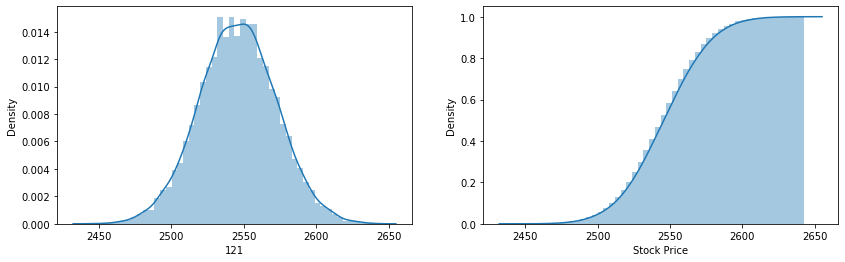

ASIANPAINT
Minutes: 121
Expected Value: $2545.78
Return: 0.15%
Probability of Breakeven: 0.5556
Beta: 0.78
Sharpe: -0.11
CAPM Return: 0.13%



/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

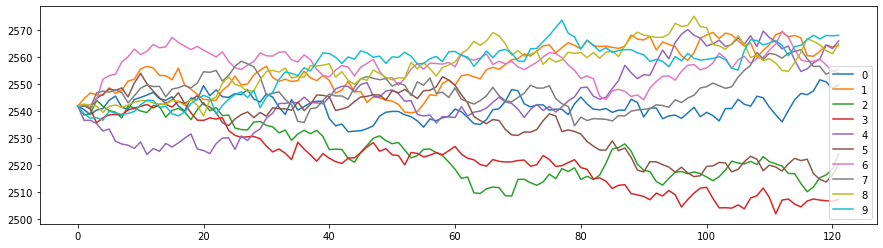

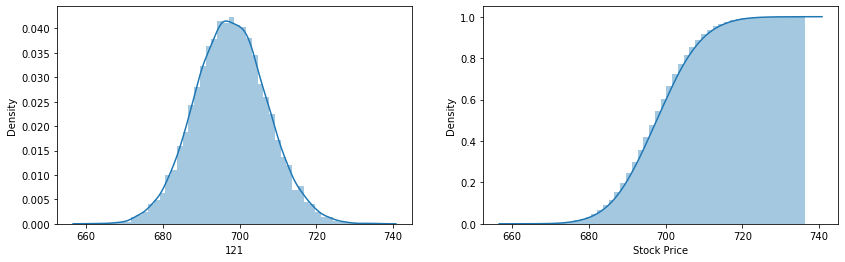

AXISBANK
Minutes: 121
Expected Value: $697.74
Return: -0.07%
Probability of Breakeven: 0.4745
Beta: 1.5
Sharpe: -0.16
CAPM Return: -2.8%



/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

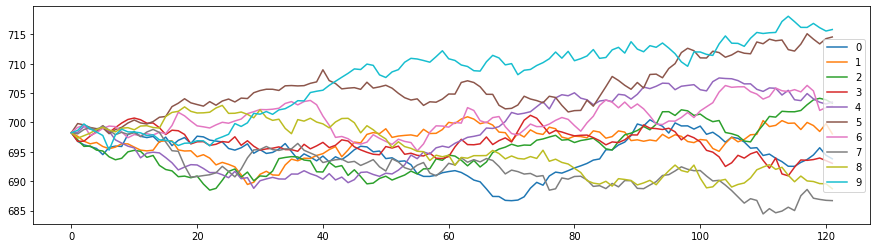

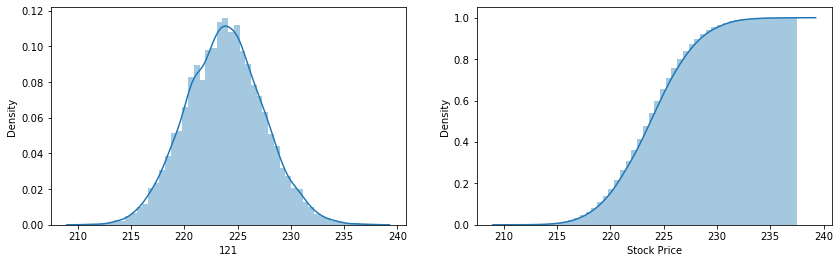

APOLLOTYRE
Minutes: 121
Expected Value: $223.78
Return: -0.08%
Probability of Breakeven: 0.4796
Beta: 1.2
Sharpe: -0.11
CAPM Return: -1.57%



/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

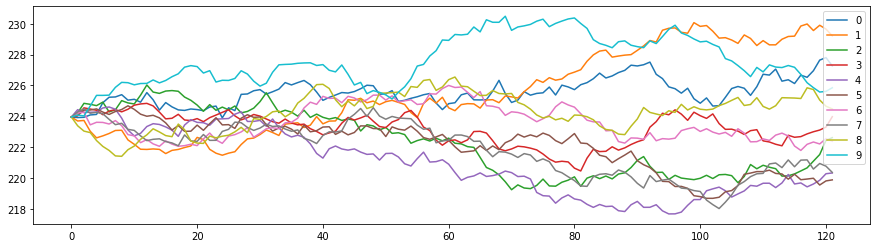

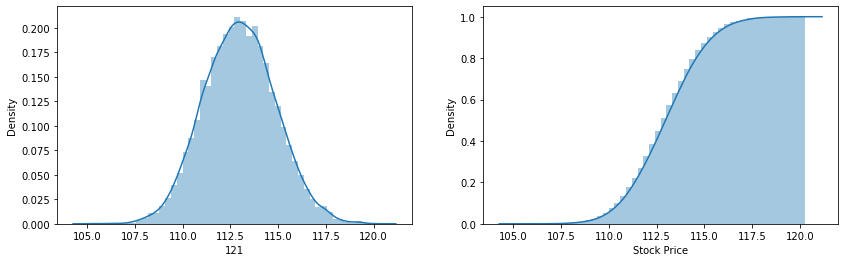

ASHOKLEY
Minutes: 121
Expected Value: $112.98
Return: -0.24%
Probability of Breakeven: 0.4406
Beta: 1.28
Sharpe: -0.11
CAPM Return: -1.89%



/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

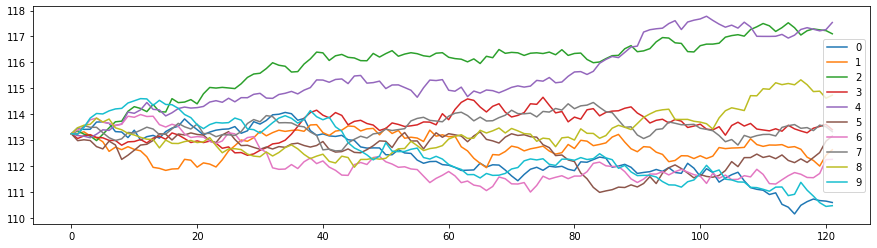

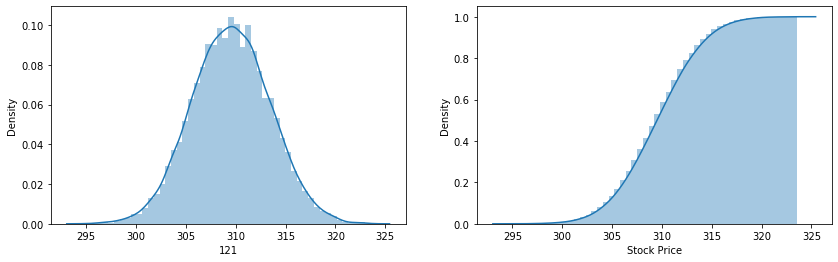

AMBUJACEM
Minutes: 121
Expected Value: $309.53
Return: 0.19%
Probability of Breakeven: 0.5567
Beta: 0.82
Sharpe: -0.1
CAPM Return: -0.04%



/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

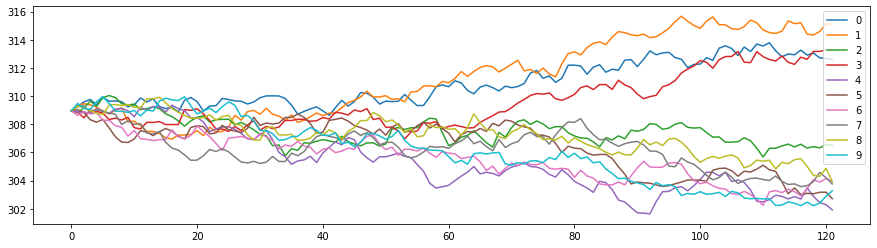

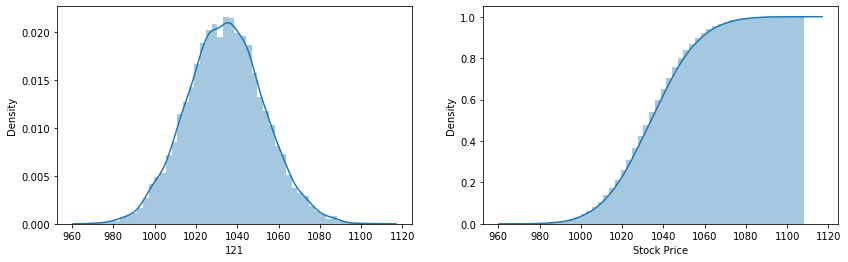

ADANIENT
Minutes: 121
Expected Value: $1034.18
Return: 0.31%
Probability of Breakeven: 0.5636
Beta: 1.2
Sharpe: -0.1
CAPM Return: -1.59%



/home/ben_dover/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

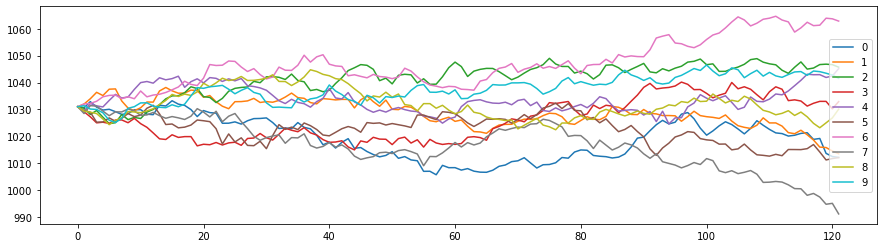

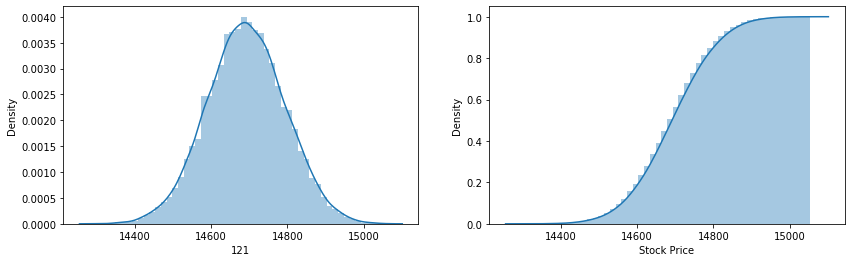

NIFTY
Minutes: 121
Expected Value: $14691.58
Return: -0.01%
Probability of Breakeven: 0.4925
Beta: 1.0
Sharpe: -0.21
CAPM Return: -0.76%



,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
ticker,,,,,,,,,,,,,,,,,,,,,
ASIANPAINT,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,...,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000,2542.000000
ASIANPAINT,2540.667001,2544.706732,2538.671738,2542.097906,2536.676021,2542.374431,2541.959281,2542.060175,2542.735069,2539.097952,...,2543.820359,2540.124044,2541.759723,2539.987782,2542.429302,2546.437931,2540.201826,2543.643005,2543.528722,2539.758354
ASIANPAINT,2538.834485,2546.855209,2539.196563,2540.922863,2536.725516,2541.054910,2542.273297,2541.383129,2542.253864,2537.522812,...,2540.367580,2541.089221,2541.494083,2543.295694,2543.132672,2543.009996,2539.784123,2543.150492,2539.721288,2536.450376
ASIANPAINT,2540.492526,2546.123544,2544.103119,2535.759488,2535.448454,2544.912091,2544.405195,2546.883276,2541.915828,2537.682946,...,2541.337842,2540.873449,2542.312399,2543.073632,2544.327868,2544.485450,2539.114659,2539.486160,2540.684940,2534.232081
ASIANPAINT,2541.070281,2545.953846,2541.948636,2537.623145,2532.754571,2546.288733,2551.941812,2547.528595,2539.653692,2536.756512,...,2546.164004,2540.440690,2541.353683,2544.649510,2547.143901,2542.415708,2537.440539,2537.541141,2538.580523,2537.349045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIFTY,14691.368984,14702.964543,14806.617390,14667.476893,14740.156078,14590.305719,14671.837129,14776.110928,14786.267396,14550.041618,...,14597.869950,14448.552742,14702.959418,14683.545812,14605.508659,14860.508319,14831.401653,14802.111623,14627.406609,14718.241653
NIFTY,14689.003447,14699.284253,14805.725649,14679.145879,14746.249210,14588.925120,14674.404898,14766.661029,14782.472441,14550.756253,...,14594.305275,14452.324132,14713.058516,14690.902681,14605.331068,14862.183575,14844.113592,14810.229227,14642.231854,14717.576260
NIFTY,14689.427182,14692.519854,14801.627530,14662.078028,14748.836823,14581.791255,14678.883082,14762.167335,14785.282279,14547.385857,...,14597.706715,14438.446197,14713.824540,14678.370112,14607.516263,14862.079410,14866.022571,14818.378565,14629.235440,14719.974690


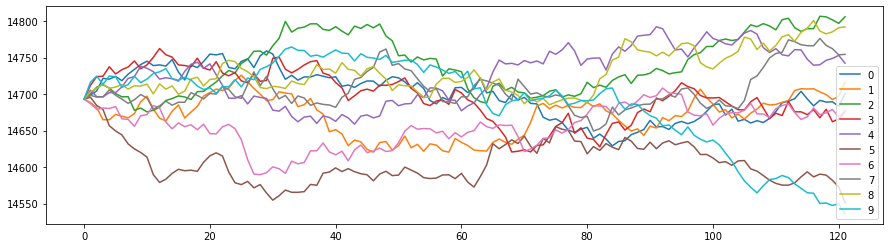

In [26]:
monte_carlo(120, 10000, plot=True)

### Portfolio Optimization

In this section we shall look at its application in portfolio optimization.
    
In this simulation, we will assign random weights to the stocks. One important point to keep in mind is that the sum of the weights should always sum up to 1. At every particular combination of these weights, we will compute the return, standard deviation and sharpe ratio of the portfolio and save it. We’ll then change the weights and assign some random values and repeat the above procedure.

The number of iterations depends on the error that the trader is willing to accept. Higher the number of iterations, higher will be the accuracy of the optimization but at the cost of computation and time.

Conditions of Portfolio Optimization:

* A portfolio which has the minimum risk for the desired level of expected return.
* A portfolio which gives the maximum expected return at the desired level of risk (risk as measured in terms of standard deviation or variance).
* A portfolio which has the maximum return to risk ratio (or Sharpe ratio).

Begin by initializing the arrays for saving the performance values from the Monte Carlo runs, and set up the Monte Carlo simulations loop. The important thing to remember is the weights, as this will select a new value each time  making each run unique. Also notice how each value you're saving (ret, vol, Sharpe) is really an array being saved with indexing per each run — so run 0 begins, randomizes weights, and calculates the return, saving it to index 0 in ret arr, and then vol saves in 0 index, and ﬁnally SR. Once you’ve looped through, you run an argmax() function in the SR arr (or whatever value you're optimizing), which will give you the optimal weight's index based on that parameter. Then index out the other 2 metrics, returns and volatility and you have your optimal portfolio.

In [27]:
def montecarlo_optimal_portfolio(trials, data_folder_path='data', optimize='sharpe', riskfree=0.0332, plot_eff = True):
    
    data = load_preprocess_data(data_folder_path)
    
#     ticker list to loop through
    tickers = data.columns
    
#     create a trials * tickers matrix for different portfolio constituent weights
    all_weights = np.zeros((trials, len(data.columns)))
    
#     create arrays of portfolio returns, volatility and sharpe for each simulation
    all_returns = np.zeros(trials)
    all_volatility = np.zeros(trials)
    all_sharpe = np.zeros(trials)
    
    log_return = log_returns(data)
    
#     looping through trials to simulate the values
    for t in range(trials):
        
#         compute random values between 0 and 1 as individual stock weights
        weights = np.random.rand(len(data.columns))
    
#         normalize weights to ensure sum = 1
        weights = weights/np.sum(weights)
    
#         set the weights as the row which matches current trial number
        all_weights[t,:]=weights
        
#         save metrics in their respective arrays at the same position as trial number
        all_returns[t] = np.sum((log_return.mean()*weights)*annualizer)
        
        all_volatility[t] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*annualizer, weights)))
        
        all_sharpe[t] = (all_returns[t]-riskfree)/all_volatility[t]
        
#     save the index of the optimal simulated value 

    if optimize == 'sharpe':
        point = all_sharpe.argmax()
    elif optimize == 'returns':
        point = all_returns.argmax()
    elif optimize == 'risk':
        point = all_volatility.argmin()
    else:
        print('optimize must be either "sharpe", "returns" or "risk"')
        
#     fetch and save the simulated weights, volatility and returns corresponding to that optimal value
    optimal_weight = all_weights[point]
    x = all_volatility[point]
    y = all_returns[point]
    
    if plot_eff == True:
        plt.figure(figsize=(14,9))
        
#         scatterplot with volatility on x axis, returns on y axis and colour based on sharpe values
        plt.scatter(all_volatility, all_returns, c=all_sharpe, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        
#         plot the optimal portfolio
        plt.scatter(x, y, c='black')
       
#     loop through tickers and save ticker - optimal weight pairs as dictionaries
    optimal_list = []
    
    for i in range(len(tickers)):
        optimal_list.append({'ticker':tickers[i],'Weights':optimal_weight[i]})
        
#     convert to df and set index as ticker for viewing individual weights later
    optimal_df = pd.DataFrame(optimal_list).set_index('ticker')
    
    return optimal_df

,Weights
ticker,
ASIANPAINT,0.314390
AXISBANK,0.001722
APOLLOTYRE,0.025505
ASHOKLEY,0.033836
AMBUJACEM,0.225746
ADANIENT,0.331042
NIFTY,0.067759


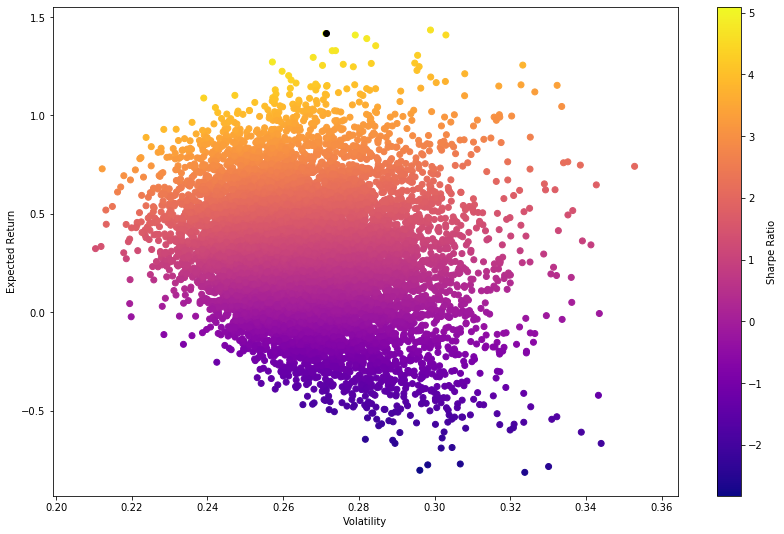

In [28]:
montecarlo_optimal_portfolio(10000)

,Weights
ticker,
ASIANPAINT,0.255090
AXISBANK,0.005255
APOLLOTYRE,0.011860
ASHOKLEY,0.002208
AMBUJACEM,0.229107
ADANIENT,0.377768
NIFTY,0.118712


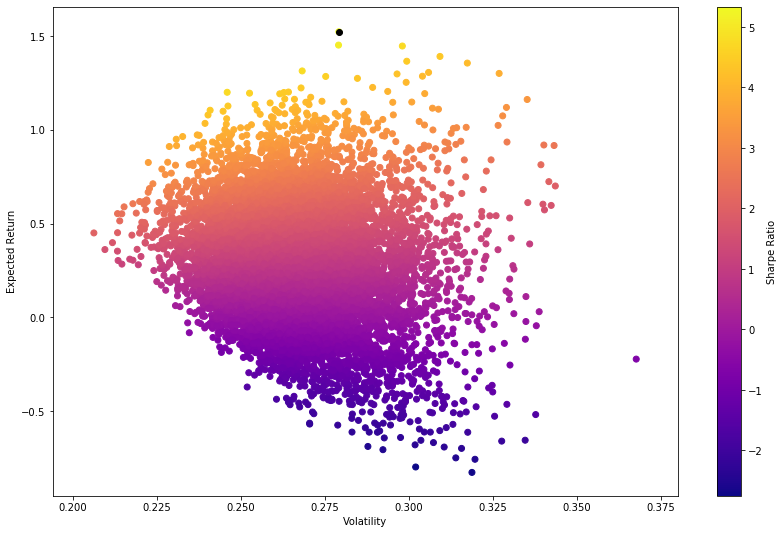

In [29]:
montecarlo_optimal_portfolio(10000, optimize='returns')

,Weights
ticker,
ASIANPAINT,0.159252
AXISBANK,0.016107
APOLLOTYRE,0.041899
ASHOKLEY,0.008283
AMBUJACEM,0.121087
ADANIENT,0.083562
NIFTY,0.569808


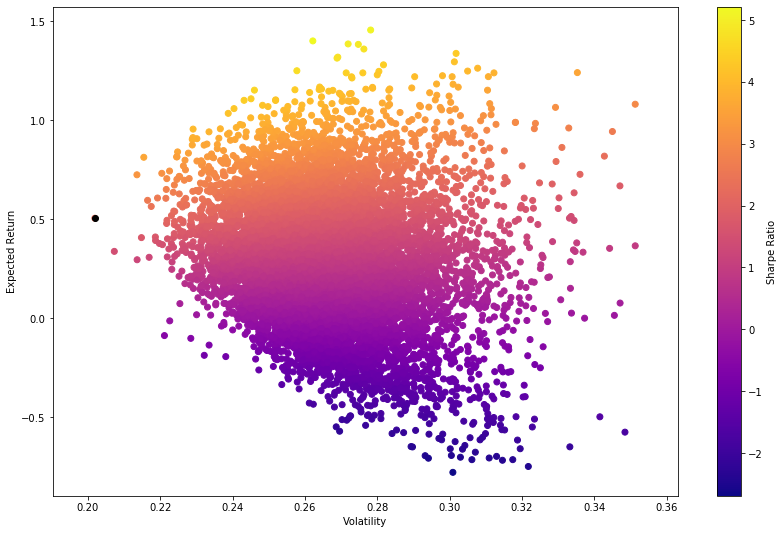

In [30]:
montecarlo_optimal_portfolio(10000, optimize='risk')